In [ ]:
!pip install --quiet tensorflow~=2.2.0 tensorflow_gcs_config~=2.2.0
import tensorflow as tf
import requests
import os
resp = requests.post("http://{}:8475/requestversion/{}".format(os.environ["COLAB_TPU_ADDR"].split(":")[0], tf.__version__))
if resp.status_code != 200:
  print("Failed to switch the TPU to TF {}".format(version))

In [ ]:
#@title
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [ ]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '138-efficientnetb4'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
OOF_PREDS_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/oof.csv'

import os
# os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [ ]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
# from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 42
seed_everything(SEED)
warnings.filterwarnings('ignore')

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [ ]:
#@title
config = {
  "HEIGHT": 512,
  "WIDTH": 512,
  "CHANNELS": 3,
  "BATCH_SIZE": 16,
  "EPOCHS": 30,
  "LEARNING_RATE": 5e-3,
  "ES_PATIENCE": 20,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB4',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-512x512',
  "INFERENCE": True
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config['LEARNING_RATE'] = config['LEARNING_RATE'] * config['BATCH_SIZE'] / 512 * REPLICAS
config

{'BASE_MODEL': 'EfficientNetB4',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 16,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-512x512',
 'EPOCHS': 30,
 'ES_PATIENCE': 20,
 'HEIGHT': 512,
 'INFERENCE': True,
 'LEARNING_RATE': 0.00125,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'WIDTH': 512}

# Load data

In [ ]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
train = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-458e4ec4a30e5d927b21efd0633fb2c0a091245fe8db3c415fde5da6'
GCS_2019_PATH = 'gs://kds-203bea6cc14c2866536ac303b09a6e77a6b3d0a371e96b680836433c'
GCS_MALIGNANT_PATH = 'gs://kds-00457c0c555bfdd50b1d2db15abd7feb19d4795037f919a3dc0abbee'

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [ ]:
#@title
def data_augment(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_shear > .2:
        if p_shear > .6:
            image = transform_shear(image, config['HEIGHT'], shear=20.)
        else:
            image = transform_shear(image, config['HEIGHT'], shear=-20.)
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .2:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    if p_cutout > .5:
        image = data_augment_cutout(image)
    
    return image


def data_augment_tta(image):
    p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    
    if p_rotation > .2:
        if p_rotation > .6:
            image = transform_rotation(image, config['HEIGHT'], rotation=45.)
        else:
            image = transform_rotation(image, config['HEIGHT'], rotation=-45.)

    if p_crop > .2:
        image = data_augment_crop(image)

    if p_rotate > .2:
        image = data_augment_rotate(image)
        
    image = data_augment_spatial(image)
    
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    return image


def data_augment_spatial(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    crop_size = tf.random.uniform([], int(config['HEIGHT']*.7), config['HEIGHT'], dtype=tf.int32)
    
    if p_crop > .5:
        image = tf.image.random_crop(image, size=[crop_size, crop_size, config['CHANNELS']])
    else:
        if p_crop > .4:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .2:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(int(config['HEIGHT'] * .1), int(config['HEIGHT'] * .1)), 
                        max_mask_size=(int(config['HEIGHT'] * .125), int(config['HEIGHT'] * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [ ]:
#@title
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0
 
def prepare_image(img, augment=None, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = augment(img)
                      
    img = tf.reshape(img, [dim, dim, 3])
            
    return img

def get_dataset(files, augment=None, shuffle=False, repeat=False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds


def get_dataset_sampling(files, augment=None, shuffle=False, repeat=False, 
                         labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), num_parallel_calls=AUTO)
    
    return ds

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

## Learning rate scheduler

Learning rate schedule: 0 to 0.00125 to 1e-06


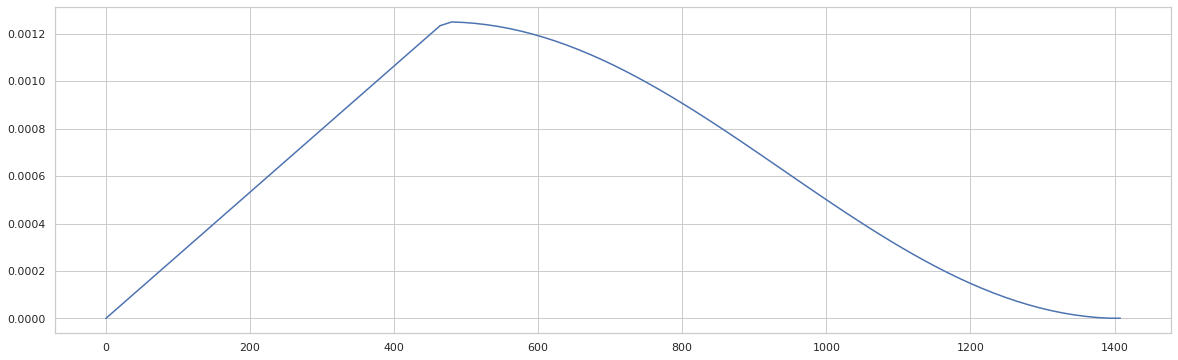

In [ ]:
#@title
steps_per_epoch = 47
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 10
lr_start = 0
lr_max = config['LEARNING_RATE']
lr_min = 1e-6
num_cycles = 1

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [cosine_with_hard_restarts_schedule_with_warmup(tf.cast(x, tf.float32), total_steps, 
                                                    warmup_steps, lr_start, lr_max, lr_min, 
                                                    num_cycles) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [ ]:
def model_fn(input_shape=(256, 256, 3)):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB4(input_shape=input_shape, 
                                    weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid', kernel_initializer='zeros', name='output')(x)

    model = Model(inputs=input_image, outputs=output)
    
    # opt = optimizers.Adam(learning_rate=config['LEARNING_RATE'])
    lr = lambda: cosine_with_hard_restarts_schedule_with_warmup(tf.cast(opt.iterations, tf.float32), 
                                                                total_steps, warmup_steps, lr_start, lr_max, lr_min, num_cycles)
    
    opt = optimizers.Adam(learning_rate=lr)
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    model.compile(optimizer=opt, loss=loss, metrics=['AUC'])

    return model

# Training

In [ ]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = []; history_list = []
preds = np.zeros((len(test), 1))

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # CREATE TRAIN AND VALIDATION SUBSETS
    TRAINING_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec' % x for x in idxT])
    # Add external data
    # TRAINING_FILENAMES += tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2+1) for x in idxT]) # 2019 data
    TRAINING_FILENAMES_2 = tf.io.gfile.glob([GCS_2019_PATH + '/train%.2i*.tfrec' % (x*2) for x in idxT]) # 2018 data
    # Add extra malignant data
    TRAINING_MALIG_FILENAMES = tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % x for x in idxT]) # 2020 data
    TRAINING_MALIG_FILENAMES_2 = tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2+1)+30) for x in idxT]) # 2019 data
    TRAINING_MALIG_FILENAMES_2 += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % ((x*2)+30) for x in idxT]) # 2018 data
    TRAINING_MALIG_FILENAMES_2 += tf.io.gfile.glob([GCS_MALIGNANT_PATH + '/train%.2i*.tfrec' % (x+15) for x in idxT]) # new data

    np.random.shuffle(TRAINING_FILENAMES)
    np.random.shuffle(TRAINING_MALIG_FILENAMES)
    ds_regular = get_dataset_sampling(TRAINING_FILENAMES, augment=data_augment, shuffle=True, repeat=True,
                                      dim=config['HEIGHT'], batch_size=config['BATCH_SIZE'])
    ds_regular_2 = get_dataset_sampling(TRAINING_FILENAMES_2, augment=data_augment, shuffle=True, repeat=True,
                                        dim=config['HEIGHT'], batch_size=config['BATCH_SIZE'])
    ds_malig = get_dataset_sampling(TRAINING_MALIG_FILENAMES, augment=data_augment, shuffle=True, repeat=True,
                                    dim=config['HEIGHT'], batch_size=config['BATCH_SIZE'])
    ds_malig_2 = get_dataset_sampling(TRAINING_MALIG_FILENAMES_2, augment=data_augment, shuffle=True, repeat=True,
                                      dim=config['HEIGHT'], batch_size=config['BATCH_SIZE'])
    # Resampled TF Dataset
    resampled_ds = tf.data.experimental.sample_from_datasets([ds_regular, ds_regular_2, ds_malig, ds_malig_2], weights=[0.4, 0.2, 0.2, 0.2])
    resampled_ds = resampled_ds.batch(config['BATCH_SIZE'] * REPLICAS).prefetch(AUTO)

    files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
    TEST_FILENAMES = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    ct_valid = count_data_items(files_valid)
    ct_test = count_data_items(TEST_FILENAMES)
    VALID_STEPS = config['TTA_STEPS'] * ct_valid/config['BATCH_SIZE']/4/REPLICAS
    TEST_STEPS = config['TTA_STEPS'] * ct_test/config['BATCH_SIZE']/4/REPLICAS
    # steps_per_epoch = (count_data_items(TRAINING_FILENAMES) / 0.6) / 10
    
    ### MODEL
    K.clear_session()
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

    model_path_last = f'{MODEL_BASE_PATH}model_{fold}_last.h5'

    ### TRAIN
    history = model.fit(resampled_ds, 
                        validation_data=get_dataset(files_valid, augment=None, shuffle=False,
                                                    repeat=False, dim=config['HEIGHT']), 
                        # steps_per_epoch=(steps_per_epoch/config['BATCH_SIZE']//REPLICAS), 
                        steps_per_epoch=steps_per_epoch, 
                        epochs=config['EPOCHS'], 
                        verbose=2).history
      
    history_list.append(history)
    # Save last model weights
    model.save_weights(model_path_last)

    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
                           labeled=True, return_image_names=True)
    oof_tar.append(np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]))
    oof_folds.append(np.ones_like(oof_tar[-1], dtype='int8')*fold)
    ds = get_dataset(files_valid, augment=None, repeat=False, dim=config['HEIGHT'],
                     labeled=False, return_image_names=True)
    oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))

    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=data_augment_tta,
                           repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_valid, steps=VALID_STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,]
    oof_pred.append(np.mean(pred.reshape((ct_valid, config['TTA_STEPS']), order='F'),axis=1))
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(TEST_FILENAMES, labeled=False, return_image_names=False, augment=data_augment_tta,
                          repeat=True, shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    pred = model.predict(ds_test, steps=TEST_STEPS, verbose=2)[:config['TTA_STEPS']*ct_test,]
    preds[:,0] += np.mean(pred.reshape((ct_test, config['TTA_STEPS']), order='F'), axis=1) / config['N_USED_FOLDS']

    ### RESULTS
    auc = roc_auc_score(oof_tar[-1], oof_pred[-1])
    oof_val.append(np.max(history['val_auc']))
    print(f'#### FOLD {fold+1} OOF AUC = {oof_val[-1]:.3f}, with TTA = {auc:.3f}')

INFO:tensorflow:Initializing the TPU system: grpc://10.79.91.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.91.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]
Epoch 1/30
47/47 - 62s - loss: 0.6602 - auc: 0.6831 - val_loss: 0.2722 - val_auc: 0.6825
Epoch 2/30
47/47 - 40s - loss: 0.5101 - auc: 0.8426 - val_loss: 0.1857 - val_auc: 0.7753
Epoch 3/30
47/47 - 40s - loss: 0.4790 - auc: 0.8665 - val_loss: 0.1845 - val_auc: 0.8366
Epoch 4/30
47/47 - 39s - loss: 0.4508 - auc: 0.8882 - val_loss: 0.2458 - val_auc: 0.9025
Epoch 5/30
47/47 - 39s - loss: 0.4478 - auc: 0.8896 - val_loss: 0.1960 - val_auc: 0.8946
Epoch 6/30
47/47 - 39s - loss: 0.4413 - auc: 0.8950 - val_loss: 0.2032 - val_auc: 0.9091
Epoch 7/30
47/47 - 40s - loss: 0.4242 - auc: 0.9056 - val_loss: 0.2310 - val_auc: 0.8319
Epoch 8/30
47/47 - 39s - loss: 0.4236 - auc: 0.9054 - val_loss: 0.4370 - val_auc: 0.8956
Epoch 9/30
47/47 - 40s - loss: 0.4266 - auc: 0.9042 - val_loss: 0.2413 - val_auc: 0.8883
Epoch 10/30
47/47 - 40s - loss: 0.4143 - auc: 0.9124 - val_loss: 0.8370 - val_auc: 0.8776
Epoch 11/30
47/47 - 40s - loss: 0.415

INFO:tensorflow:Initializing the TPU system: grpc://10.79.91.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.91.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]
Epoch 1/30
47/47 - 61s - loss: 0.6566 - auc: 0.6715 - val_loss: 0.4362 - val_auc: 0.6611
Epoch 2/30
47/47 - 39s - loss: 0.5145 - auc: 0.8381 - val_loss: 0.2489 - val_auc: 0.6575
Epoch 3/30
47/47 - 40s - loss: 0.4756 - auc: 0.8710 - val_loss: 0.1894 - val_auc: 0.7844
Epoch 4/30
47/47 - 39s - loss: 0.4510 - auc: 0.8875 - val_loss: 0.2689 - val_auc: 0.8719
Epoch 5/30
47/47 - 39s - loss: 0.4539 - auc: 0.8845 - val_loss: 0.2100 - val_auc: 0.8755
Epoch 6/30
47/47 - 39s - loss: 0.4359 - auc: 0.8983 - val_loss: 0.1974 - val_auc: 0.8562
Epoch 7/30
47/47 - 39s - loss: 0.4293 - auc: 0.9023 - val_loss: 0.3076 - val_auc: 0.8884
Epoch 8/30
47/47 - 39s - loss: 0.4339 - auc: 0.8993 - val_loss: 0.2630 - val_auc: 0.8364
Epoch 9/30
47/47 - 39s - loss: 0.4113 - auc: 0.9132 - val_loss: 0.2156 - val_auc: 0.8221
Epoch 10/30
47/47 - 39s - loss: 0.4242 - auc: 0.9050 - val_loss: 0.2364 - val_auc: 0.8755
Epoch 11/30
47/47 - 39s - loss: 0.412

INFO:tensorflow:Initializing the TPU system: grpc://10.79.91.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.91.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]
Epoch 1/30
47/47 - 61s - loss: 0.6601 - auc: 0.6628 - val_loss: 0.4057 - val_auc: 0.6521
Epoch 2/30
47/47 - 39s - loss: 0.5104 - auc: 0.8432 - val_loss: 0.1818 - val_auc: 0.7561
Epoch 3/30
47/47 - 39s - loss: 0.4780 - auc: 0.8684 - val_loss: 0.1801 - val_auc: 0.8469
Epoch 4/30
47/47 - 39s - loss: 0.4550 - auc: 0.8853 - val_loss: 0.3362 - val_auc: 0.8748
Epoch 5/30
47/47 - 39s - loss: 0.4542 - auc: 0.8856 - val_loss: 0.1992 - val_auc: 0.9171
Epoch 6/30
47/47 - 39s - loss: 0.4393 - auc: 0.8950 - val_loss: 0.2080 - val_auc: 0.8723
Epoch 7/30
47/47 - 39s - loss: 0.4360 - auc: 0.8979 - val_loss: 0.2000 - val_auc: 0.8929
Epoch 8/30
47/47 - 39s - loss: 0.4179 - auc: 0.9087 - val_loss: 0.2426 - val_auc: 0.8261
Epoch 9/30
47/47 - 39s - loss: 0.4291 - auc: 0.9035 - val_loss: 0.4577 - val_auc: 0.9087
Epoch 10/30
47/47 - 39s - loss: 0.4322 - auc: 0.9003 - val_loss: 0.2470 - val_auc: 0.8247
Epoch 11/30
47/47 - 39s - loss: 0.416

INFO:tensorflow:Initializing the TPU system: grpc://10.79.91.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.91.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]
Epoch 1/30
47/47 - 62s - loss: 0.6574 - auc: 0.6698 - val_loss: 0.3744 - val_auc: 0.7072
Epoch 2/30
47/47 - 39s - loss: 0.5120 - auc: 0.8397 - val_loss: 0.1910 - val_auc: 0.7423
Epoch 3/30
47/47 - 39s - loss: 0.4865 - auc: 0.8613 - val_loss: 0.2119 - val_auc: 0.8451
Epoch 4/30
47/47 - 39s - loss: 0.4613 - auc: 0.8814 - val_loss: 0.2745 - val_auc: 0.8956
Epoch 5/30
47/47 - 39s - loss: 0.4428 - auc: 0.8932 - val_loss: 0.2510 - val_auc: 0.8854
Epoch 6/30
47/47 - 39s - loss: 0.4258 - auc: 0.9043 - val_loss: 0.3242 - val_auc: 0.9066
Epoch 7/30
47/47 - 39s - loss: 0.4293 - auc: 0.9025 - val_loss: 0.3256 - val_auc: 0.9088
Epoch 8/30
47/47 - 39s - loss: 0.4223 - auc: 0.9064 - val_loss: 0.4169 - val_auc: 0.8755
Epoch 9/30
47/47 - 39s - loss: 0.4148 - auc: 0.9115 - val_loss: 0.4464 - val_auc: 0.8740
Epoch 10/30
47/47 - 39s - loss: 0.4258 - auc: 0.9048 - val_loss: 0.4197 - val_auc: 0.8551
Epoch 11/30
47/47 - 39s - loss: 0.420

INFO:tensorflow:Initializing the TPU system: grpc://10.79.91.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.91.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.



FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]
Epoch 1/30
47/47 - 60s - loss: 0.6611 - auc: 0.6529 - val_loss: 0.4648 - val_auc: 0.6579
Epoch 2/30
47/47 - 39s - loss: 0.5101 - auc: 0.8416 - val_loss: 0.2327 - val_auc: 0.7177
Epoch 3/30
47/47 - 39s - loss: 0.4693 - auc: 0.8737 - val_loss: 0.2299 - val_auc: 0.8366
Epoch 4/30
47/47 - 39s - loss: 0.4556 - auc: 0.8850 - val_loss: 0.2062 - val_auc: 0.8570
Epoch 5/30
47/47 - 39s - loss: 0.4378 - auc: 0.8970 - val_loss: 0.2553 - val_auc: 0.8857
Epoch 6/30
47/47 - 39s - loss: 0.4342 - auc: 0.8983 - val_loss: 0.3004 - val_auc: 0.8900
Epoch 7/30
47/47 - 39s - loss: 0.4234 - auc: 0.9067 - val_loss: 0.3049 - val_auc: 0.9030
Epoch 8/30
47/47 - 39s - loss: 0.4265 - auc: 0.9043 - val_loss: 0.6502 - val_auc: 0.8957
Epoch 9/30
47/47 - 39s - loss: 0.4261 - auc: 0.9049 - val_loss: 0.2203 - val_auc: 0.8938
Epoch 10/30
47/47 - 39s - loss: 0.4190 - auc: 0.9080 - val_loss: 0.2952 - val_auc: 0.8882
Epoch 11/30
47/47 - 39s - loss: 0.418

## Model loss graph

Fold: 1


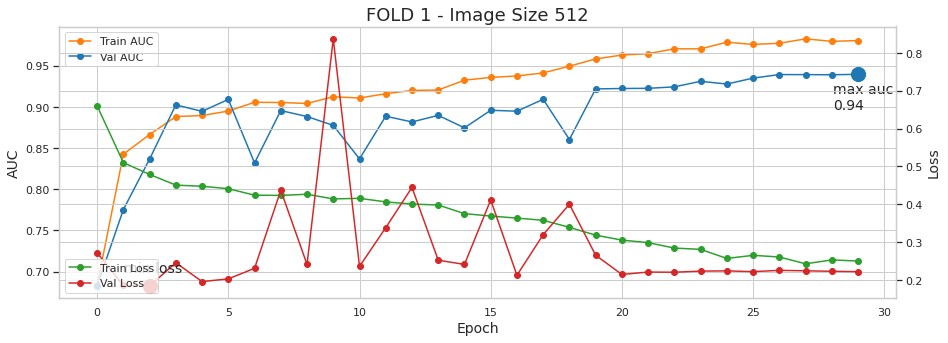

Fold: 2


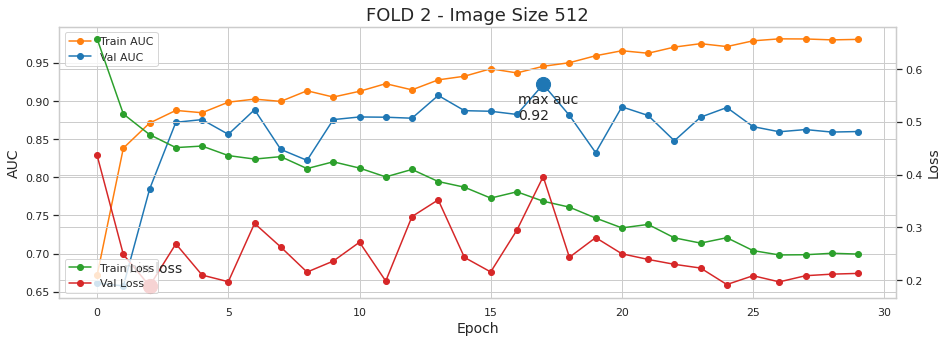

Fold: 3


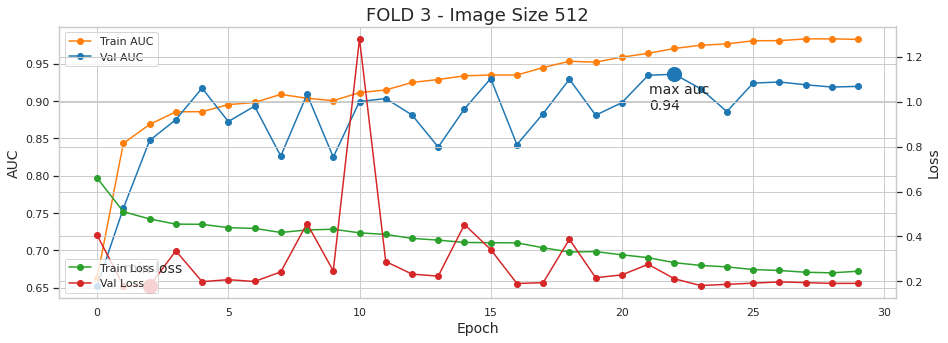

Fold: 4


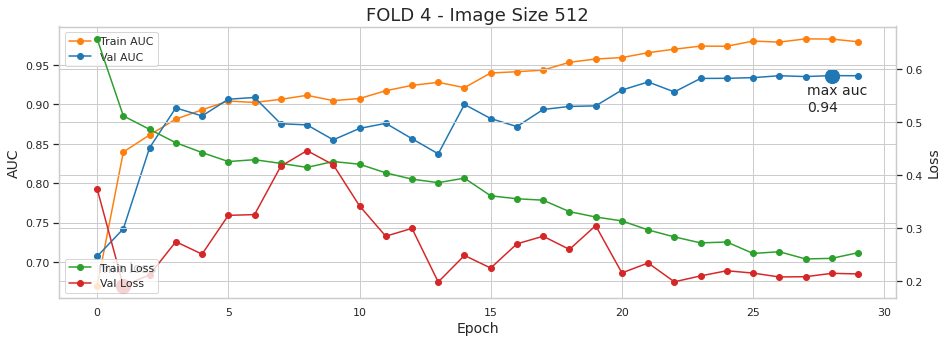

Fold: 5


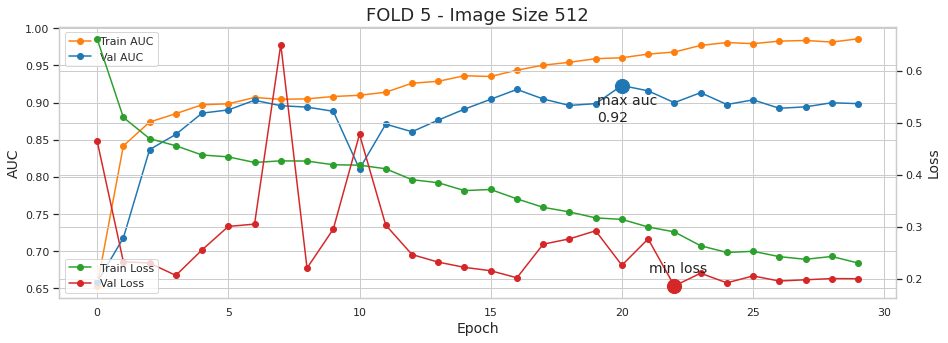

In [ ]:
#@title
for n_fold, history in enumerate(history_list):
    print(f'Fold: {n_fold + 1}')
    epochs = np.arange(len(history['loss']))
    plt.figure(figsize=(15,5))
    plt.plot(epochs, history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(epochs, history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax(history['val_auc'])
    y = np.max(history['val_auc'])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(epochs, history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(epochs, history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'])
    y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('FOLD %i - Image Size %i' % (n_fold+1, config['HEIGHT']), size=18)
    plt.legend(loc=3)
    plt.show()

# Model evaluation

In [ ]:
#@title
# COMPUTE OVERALL OOF AUC
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
oof = np.concatenate(oof_pred)
auc = roc_auc_score(true, oof)
print(f'Overall OOF AUC with TTA = {auc:.3f}')

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(image_name=names, fold=folds, target=true, pred=oof))
df_oof.to_csv(OOF_PREDS_PATH, index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.922


,image_name,fold,target,pred
0,ISIC_2637011,0,0,0.103655
1,ISIC_0076262,0,0,0.034784
2,ISIC_0074268,0,0,0.017850
3,ISIC_0015719,0,0,0.014612
4,ISIC_0082543,0,0,0.018422


# Visualize test predictions

Test predictions 460|10522
Top 10 samples


,image_name,target
9905,ISIC_0052060,0.026780
1443,ISIC_0052349,0.023896
3120,ISIC_0058510,0.025213
4870,ISIC_0073313,0.031691
5494,ISIC_0073502,0.022557
4537,ISIC_0074618,0.030585
4819,ISIC_0076801,0.076847
7203,ISIC_0077586,0.025228
10897,ISIC_0082004,0.096656
5093,ISIC_0082785,0.023014


Top 10 positive samples


,image_name,target
2280,ISIC_0112420,0.945452
8522,ISIC_0155983,0.781503
1782,ISIC_0169906,0.667651
9528,ISIC_0178235,0.510312
1215,ISIC_0200120,0.515401
2519,ISIC_0208233,0.677500
3184,ISIC_0216447,0.642220
9464,ISIC_0220438,0.873057
5389,ISIC_0235501,0.870749
5072,ISIC_0259209,0.848649


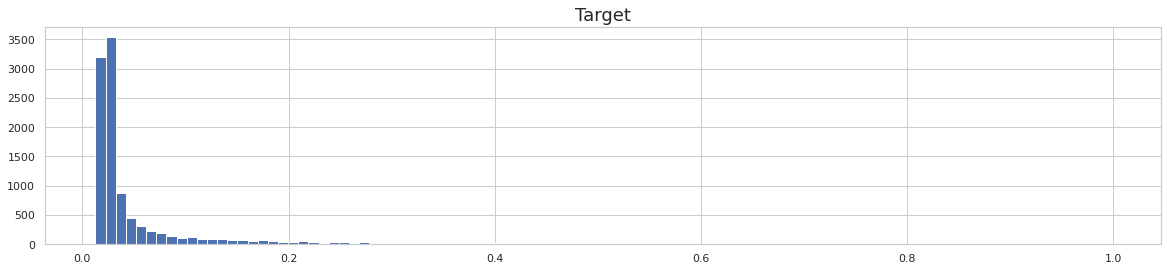

In [ ]:
#@title
ds = get_dataset(TEST_FILENAMES, augment=False, repeat=False, dim=config['HEIGHT'],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])

submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name')

print(f"Test predictions {len(submission[submission['target'] > .5])}|{len(submission[submission['target'] <= .5])}")

print('Top 10 samples')
display(submission.head(10))

print('Top 10 positive samples')
display(submission.query('target > .5').head(10))

fig = plt.subplots(figsize=(20, 4))
plt.hist(submission['target'], bins=100)
plt.title('Target', size=18)
plt.show()

# Test set predictions

In [ ]:
#@title
display(submission.head(10))
display(submission.describe().T)

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

,image_name,target
9905,ISIC_0052060,0.026780
1443,ISIC_0052349,0.023896
3120,ISIC_0058510,0.025213
4870,ISIC_0073313,0.031691
5494,ISIC_0073502,0.022557
4537,ISIC_0074618,0.030585
4819,ISIC_0076801,0.076847
7203,ISIC_0077586,0.025228
10897,ISIC_0082004,0.096656
5093,ISIC_0082785,0.023014


,count,mean,std,min,25%,50%,75%,max
target,10982.0,0.087753,0.16168,0.012737,0.021974,0.026721,0.057017,0.996609
